In [357]:
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
import numpy as np
# Read the wav file
sample_rate, data = wavfile.read('igloo.wav')

sample_rate, data


(48000,
 array([[-12,  11],
        [  3,  -2],
        [  2,  -3],
        ...,
        [  0,   0],
        [  0,   0],
        [  0,   0]], dtype=int16))

In [358]:
# Normalize to mono
data = data.sum(axis=1) / 2

data

array([-0.5,  0.5, -0.5, ...,  0. ,  0. ,  0. ])

In [359]:
# Perform the Fourier transform
frequencies, times, Zxx = signal.stft(data, fs=sample_rate, nperseg=sample_rate, noverlap=sample_rate//2)
mask = (frequencies > 20) & (frequencies < 8000)
frequencies = frequencies[mask]
Zxx = Zxx[mask, :]

len(times)

523

In [360]:
# Take absolute value to get magnitude (power)
Zxx = np.abs(Zxx)

Zxx

array([[0.27778064, 0.25361732, 0.32132091, ..., 1.70561042, 0.12380305,
        0.0108613 ],
       [0.32432737, 0.40715953, 0.63166282, ..., 1.38697669, 0.10042257,
        0.01014562],
       [0.38593432, 0.45820306, 0.37831652, ..., 0.64973314, 0.06405027,
        0.01132062],
       ...,
       [2.02522533, 2.27297473, 0.17062422, ..., 0.43332777, 0.06206493,
        0.01071073],
       [3.24298005, 2.98104094, 0.11477894, ..., 0.61977379, 0.13388938,
        0.01071227],
       [4.03090199, 4.23394001, 0.13323776, ..., 0.69474339, 0.12420223,
        0.01007395]])

In [361]:
# Now you can perform your frequency binning on Zxx, just remember it needs to be done for each column (time step)
num_bins = 5

bin_edges = np.logspace(np.log10(min(frequencies)+1), np.log10(max(frequencies)), num_bins+1)
bin_medians = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
bin_freqs = np.digitize(frequencies, bins=bin_edges)

bin_vols_over_time = []
for t in range(Zxx.shape[1]):
    bin_vols = [np.sum(Zxx[bin_freqs==i, t]) for i in range(1, num_bins+1)]
    bin_vols_over_time.append(bin_vols)


bin_vols_over_time = np.array(bin_vols_over_time)
bin_edges

array([  22.        ,   71.53939845,  232.6311605 ,  756.46787653,
       2459.87531074, 7999.        ])

In [367]:
# Normalize the volumes to be between 0 and 1, then multiply by 8 and round to the nearest integer
bin_vols_over_time = bin_vols_over_time / np.max(bin_vols_over_time)
bin_vols_over_time = np.round(bin_vols_over_time * 8).astype(int)

In [368]:
import matplotlib.pyplot as plt
# Create a new figure



/var/folders/7l/92mph18d5nj1f6l32ly6l4zr0000gn/T/ipykernel_34603/2475998096.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(times, [20 * np.log10(vol_over_time[bin_index]) for vol_over_time in bin_vols_over_time], linewidth=0.5)


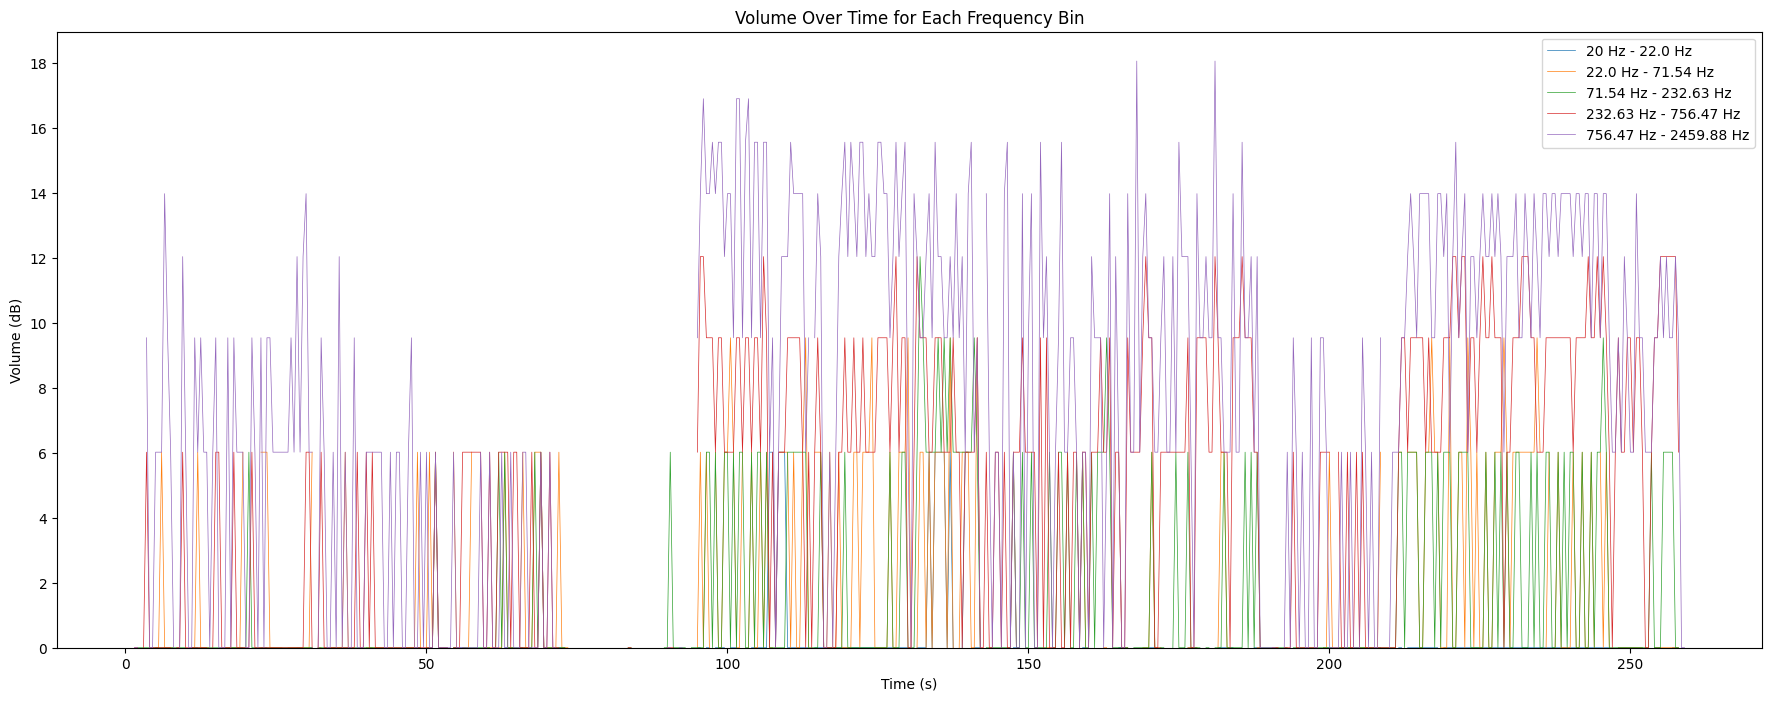

In [374]:
# Create a new figure
plt.figure(figsize=(22, 8))

# Generate lines for each frequency bin
for bin_index in range(num_bins):
    plt.plot(times, [20 * np.log10(vol_over_time[bin_index]) for vol_over_time in bin_vols_over_time], linewidth=0.5)

maxes = list(bin_edges)
maxes.append(9500)
mins = list(bin_edges)
mins.insert(0, 20)

# Add some labels
plt.xlabel('Time (s)')
plt.ylabel('Volume (dB)')
# Make the y label only display integer values
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylim(bottom=0)
plt.legend(['{} Hz - {} Hz'.format(round(mins[i],2), round(maxes[i],2)) for i in range(num_bins)])
plt.title('Volume Over Time for Each Frequency Bin')

# Display the plot
plt.show()


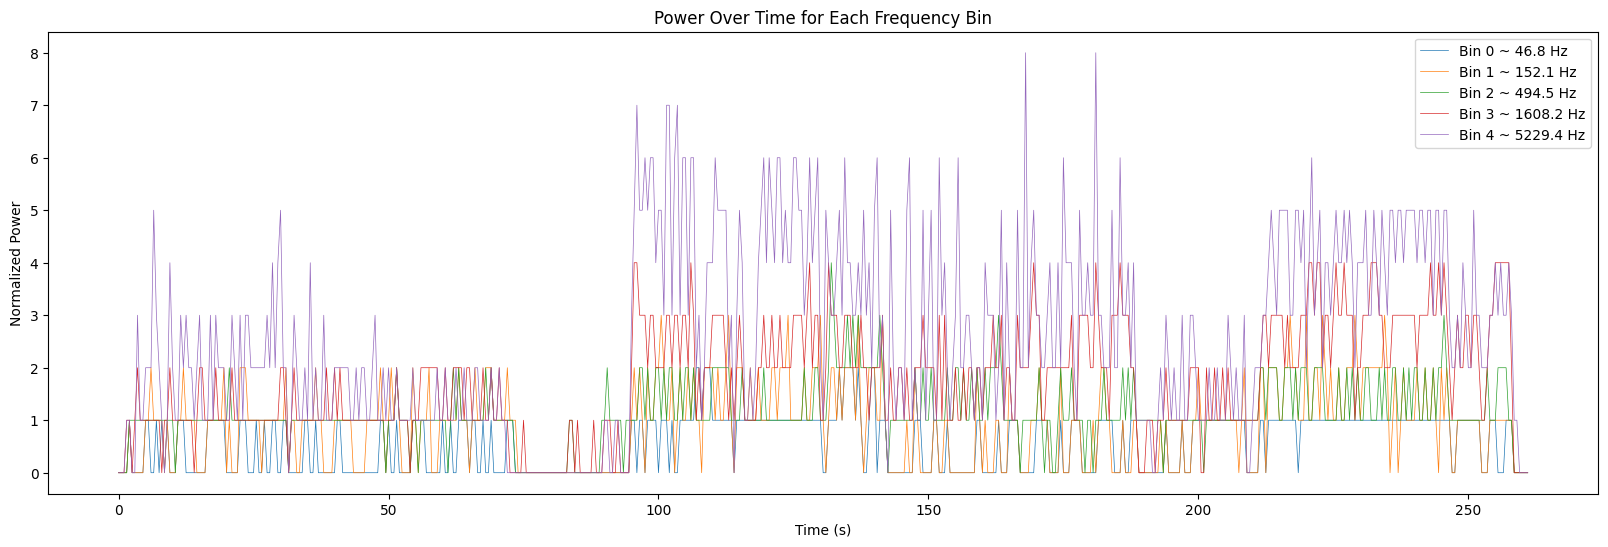

In [372]:
# For each bin, we want to plot a line
plt.figure(figsize=(20, 6))

for i in range(num_bins):
    # Get the power values of the current bin over time
    power_values = [vols[i] for vols in bin_vols_over_time]
    # Plot a line for the current bin
    plt.plot(times, power_values, label=f'Bin {i} ~ {bin_medians[i]:.1f} Hz', linewidth=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Normalized Power')
plt.title('Power Over Time for Each Frequency Bin')
plt.legend()
plt.show()

In [366]:
bin_medians

[46.76969922655629,
 152.08527947731102,
 494.5495185172882,
 1608.171593636512,
 5229.437655369978]

In [375]:
# Here is the arduino sending part
import pygame
import serial
import time

# Initialize the mixer module
pygame.mixer.init()

# Load the music file
pygame.mixer.music.load('igloo.wav')

# Start playing the music
pygame.mixer.music.play()

# Create a serial object
ser = serial.Serial('/dev/cu.usbmodem24401', 9600)

# Wait for connection to establish
time.sleep(2)

# Assuming your data is stored in bin_vols_over_time
for t in range(bin_vols_over_time.shape[0]):
    data = bin_vols_over_time[t]
    data_string = ",".join(map(str, data)) + "\n"
    ser.write(data_string.encode())

    # Wait for a fourth of a second before sending the next data
    time.sleep(0.25)

# Close the serial connection
ser.close()


pygame 2.5.0 (SDL 2.28.0, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


AttributeError: module 'serial' has no attribute 'Serial'

In [376]:
pygame.mixer.music.stop()